# Edge Online Learning

In this notebook, we will train a simple model that will be updated on the device using incoming data.

Tensorflow Lite does not support training on device CPU (yet), so we have to use the full version of Tensorflow. The implication is that models should be simple so that incremental training is not prohibitively expensive on the device.

1. Train simple model incrementally using Keras (Tensorflow backend)
2. Deploy full Tensorflow model on Raspberry Pi 3
3. Continue training with incoming data on Raspberry Pi 3

The model we will train is a binary classification gesture detector. The gesture data collection is covered separately. This notebook covers the machine learning and deployment portions.

The gesture data consists of accelerometer and compass readings collected from the BBC micro:bit. The target is True or False, depending on whether the gesture is happening.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, Flatten
from tensorflow.keras.callbacks import ModelCheckpoint

sns.set(style='whitegrid')
%matplotlib inline

## Load initial dataset

Upload your data.csv to the Files tab of your Colab session before running the cell below.

(Note that you should not put it in the sample_data folder)

In [3]:
url = './data1.csv'

df = pd.read_csv(url, names=['Gesture', 'AccX', 'AccY', 'AccZ', 'Heading'])
df.head()

,Gesture,AccX,AccY,AccZ,Heading
0,False,4,120,-1020,320
1,False,12,116,-1016,321
2,False,4,116,-1012,320
3,False,4,120,-1008,320
4,False,4,116,-1028,319


In [4]:
# convert True to 1 and False to 0
# in this case we are just converting boolean types
# if converting non boolean types, use df['Gesture'].map(...)
df['Gesture_enc'] = df['Gesture'].astype('int8')
df.head()

,Gesture,AccX,AccY,AccZ,Heading,Gesture_enc
0,False,4,120,-1020,320,0
1,False,12,116,-1016,321,0
2,False,4,116,-1012,320,0
3,False,4,120,-1008,320,0
4,False,4,116,-1028,319,0


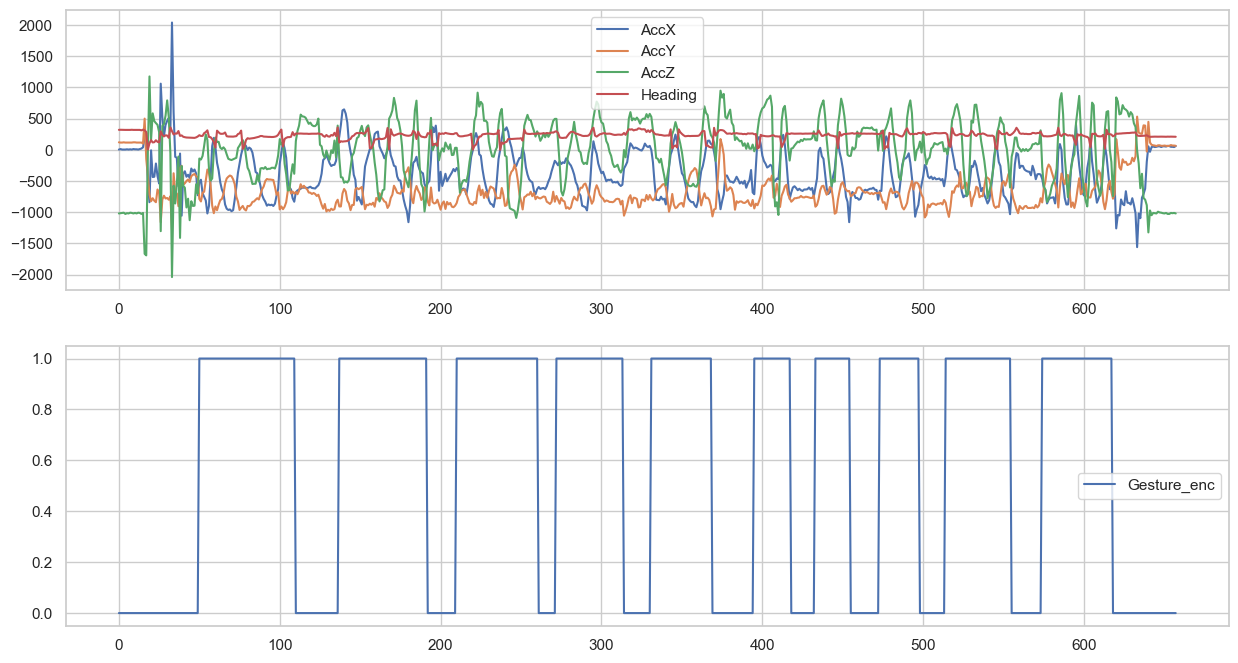

In [5]:
# plot the data, coloured based on whether gesture is recognized

fig, ax = plt.subplots(figsize=(15, 8), nrows=2)

df[['AccX', 'AccY', 'AccZ', 'Heading']].plot(ax=ax[0])
df[['Gesture_enc']].plot(ax=ax[1])
plt.show()

In [6]:
# scale the data and plot again to see more patterns

scaler = MinMaxScaler(feature_range=(-1, 1))
scaled_data = scaler.fit_transform(df[['AccX', 'AccY', 'AccZ', 'Heading']])

scaled_df = pd.DataFrame(scaled_data,
                         columns=['AccX_scaled', 'AccY_scaled', 'AccZ_scaled', 'Heading_scaled'])
scaled_df.head()

,AccX_scaled,AccY_scaled,AccZ_scaled,Heading_scaled
0,-0.131111,0.543237,-0.365672,0.782730
1,-0.126667,0.538803,-0.363184,0.788301
2,-0.131111,0.538803,-0.360697,0.782730
3,-0.131111,0.543237,-0.358209,0.782730
4,-0.131111,0.538803,-0.370647,0.777159


### Exercise 2: Inspecting the pre-processed data
<p>
<font color="red">
Run the cell below to generate a plot of your gesture data.
</font>
</p>
<p>
<font color="green">
Submission:
Paste your plot into the submission worksheet</li>
</font>
</p>

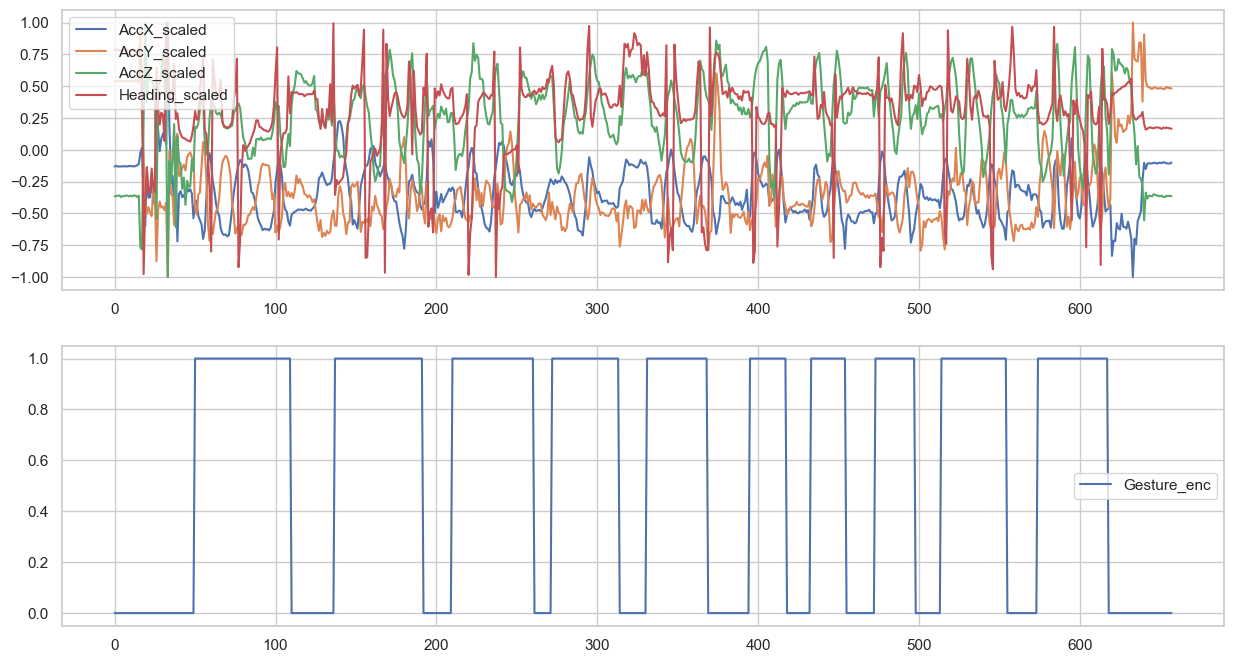

In [7]:
# plot the data, coloured based on whether gesture is recognized

fig, ax = plt.subplots(figsize=(15, 8), nrows=2)

scaled_df.plot(ax=ax[0])
df[['Gesture_enc']].plot(ax=ax[1])
plt.show()

## Preparing data for training

From the plot above, you should be able to find some consistent patterns that are associated with your gesture. 

Let's apply windowing so that the past "window" of samples will be used for prediction. This is a multi-variate time series dataset.

Estimate the width of the patterns to determine what window to use for prediction.

Change the `timesteps` parameter to match your window size, for best results.

In [8]:
# convert the time series so that each entry contains a series of timesteps.
# Before: rows, features
# After: rows, timesteps, features
# Note that some rows will be removed because we are taking a window of values.

# TODO: Change this to match your gesture width.
timesteps = 20

# we will use the scaled version of the features
print('Before', scaled_df.shape) # (rows, features)

rolling_indexes = [(range(i, i+timesteps))
                   for i in range(scaled_df.shape[0]-timesteps)]

X_sequence = np.take(scaled_df.values, rolling_indexes, axis=0)
print('After', X_sequence.shape) # (rows, timesteps, features)

Before (658, 4)
After (638, 20, 4)


In [9]:
# compute y based on rolling average of window values
# make sure y is the same length as X_sequence

target = 'Gesture_enc'
print('Before', df[target].shape)

# rolling average, using numpy to avoid a dependency on pandas
# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
y = np.convolve(df[target].values, np.ones((timesteps,))/timesteps, mode='valid')

# shift forward by 1
y = y[1:]

# apply a threshold to convert to 1 and 0
y = np.where(y >= 0.5, 1, 0)

print('After', y.shape)

Before (658,)
After (638,)


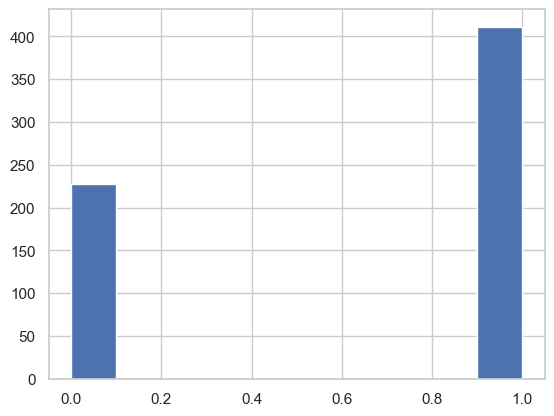

In [10]:
# check for imbalance
# imbalanced classes will make it harder to train.
# Ideally, a 50:50 ratio is preferred. Slightly imbalance is okay, but no more than 5x.
plt.hist(y)
plt.show()

In [11]:
# create training and validation set
X_train, X_val, y_train, y_val = train_test_split(X_sequence, y, test_size=0.1,
                                                  stratify=y)

X_train.shape, X_val.shape, y_train.shape, y_val.shape

((574, 20, 4), (64, 20, 4), (574,), (64,))

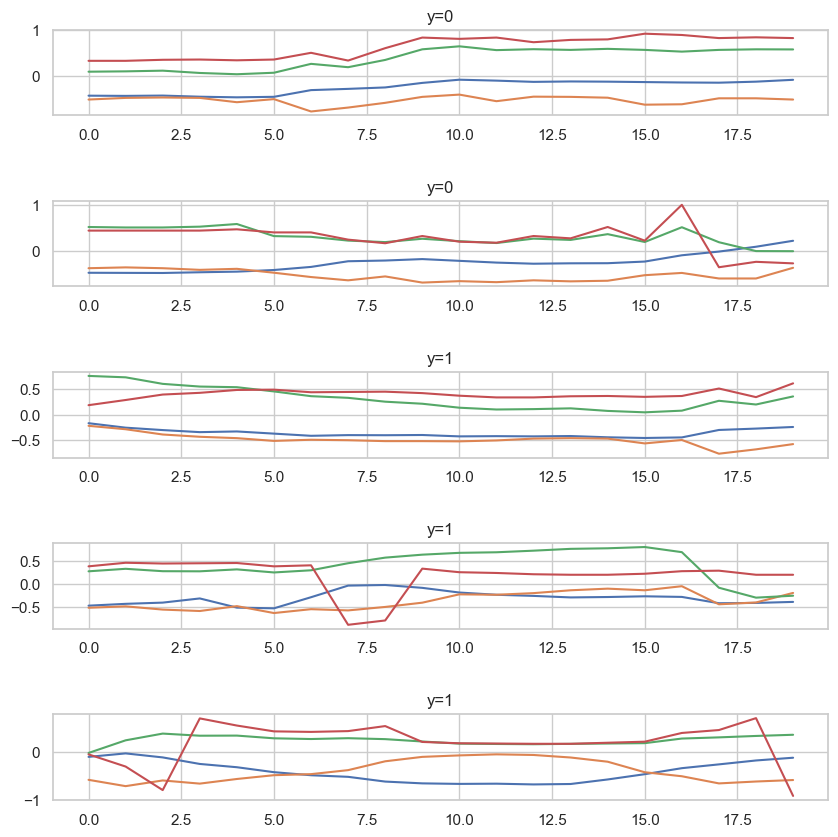

In [12]:
# visualise a sampling of windows

n = 5
sample_X, sample_y = X_train[:n], y_train[:n]

fig, axes = plt.subplots(nrows=n, figsize=(10, 10))
plt.subplots_adjust(hspace=1)

for i in range(n):
  axes[i].plot(sample_X[i])
  axes[i].set_title(f'y={sample_y[i]}')
  
plt.show()

## Training



In [13]:
model = Sequential()

# input_shape=(timesteps, features)
model.add(Conv1D(64, kernel_size=3,
                 input_shape=(X_train.shape[1], X_train.shape[2]),
                 activation='relu'))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 64)            832       
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                73792     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 74,689
Trainable params: 74,689
Non-trainable params: 0
_________________________________________________________________


2024-02-20 22:52:47.921947: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-20 22:52:47.923857: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 14. Tune using inter_op_parallelism_threads for best performance.


In [14]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [15]:
mc = ModelCheckpoint('./cnn_online.h5', save_best_only=True)

In [16]:
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_val, y_val), callbacks=[mc])

Train on 574 samples, validate on 64 samples
Epoch 1/20
574/574 [==============================] - 1s 1ms/sample - loss: 0.6287 - acc: 0.6916 - val_loss: 0.5568 - val_acc: 0.7656
Epoch 2/20
574/574 [==============================] - 0s 194us/sample - loss: 0.5109 - acc: 0.7509 - val_loss: 0.4589 - val_acc: 0.8281
Epoch 3/20
574/574 [==============================] - 0s 198us/sample - loss: 0.4337 - acc: 0.8293 - val_loss: 0.3843 - val_acc: 0.8281
Epoch 4/20
574/574 [==============================] - 0s 200us/sample - loss: 0.3632 - acc: 0.8693 - val_loss: 0.3497 - val_acc: 0.8750
Epoch 5/20
574/574 [==============================] - 0s 201us/sample - loss: 0.3182 - acc: 0.8780 - val_loss: 0.3124 - val_acc: 0.9219
Epoch 6/20
574/574 [==============================] - 0s 196us/sample - loss: 0.2884 - acc: 0.9024 - val_loss: 0.2783 - val_acc: 0.9062
Epoch 7/20
574/574 [==============================] - 0s 177us/sample - loss: 0.2510 - acc: 0.9216 - val_loss: 0.2802 - val_acc: 0.9375
Epoch

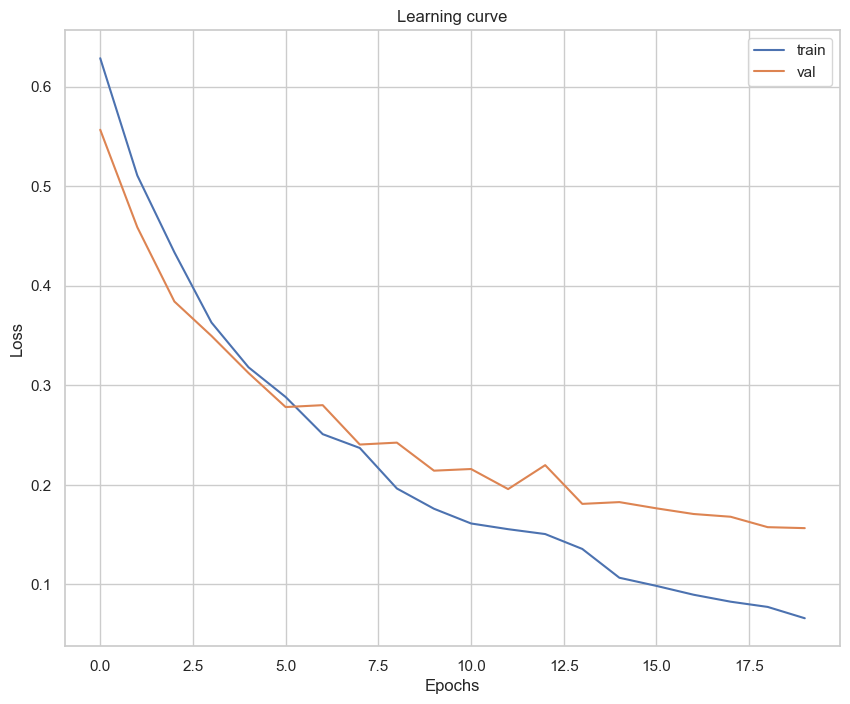

In [17]:
fig, ax = plt.subplots(figsize=(10, 8))
ax.plot(history.history['loss'], label='train')
ax.plot(history.history['val_loss'], label='val')
ax.legend()
ax.set_title('Learning curve')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.show()

## Training from checkpoint

We will load a checkpoint of the model and use it for incremental training.

In [18]:
# load the checkpoint
checkpoint = load_model('./cnn_online.h5')
checkpoint.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 18, 64)            832       
_________________________________________________________________
flatten (Flatten)            (None, 1152)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                73792     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 74,689
Trainable params: 74,689
Non-trainable params: 0
_________________________________________________________________


In [19]:
# continue training for 1 epoch (just to test)
history = checkpoint.fit(X_train, y_train, epochs=1,
                         validation_data=(X_val, y_val))

Train on 574 samples, validate on 64 samples
574/574 [==============================] - 0s 871us/sample - loss: 0.0626 - acc: 0.9878 - val_loss: 0.1577 - val_acc: 0.9531


## Preparing for Deployment

We will define/save the following for deployment on a Raspberry Pi:

1. Pre-processors: scaler, windowing, rolling average
2. Checkpoint
3. Validation dataset (for overfitting check)

In [20]:
# These are actually not pickled, but will be defined on the Raspberry Pi

def create_windows(X, timesteps):
  """convert the time series so that each entry contains a series of timesteps.
  Before: rows, features
  After: rows, timesteps, features
  """  
  rolling_indexes = [(range(i, i+timesteps))
                     for i in range(X.shape[0]-timesteps)]

  X_out = np.take(X, rolling_indexes, axis=0)
    
  return X_out

def create_rolling_average(y, timesteps):
  """compute y based on rolling average of window values
  https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
  """
  y_out = np.convolve(y, np.ones((timesteps,))/timesteps, mode='valid')

  # shift forward by 1
  y_out = y_out[1:]

  # apply a threshold to convert to 1 and 0
  y_out = np.where(y_out >= 0.5, 1, 0)

  return y_out

In [21]:
# Save scaler, validation set

for_training = {
    'scaler': scaler,
    'X_val': X_val,
    'y_val': y_val
}

pickle.dump(for_training, open('./preprocessors_and_data.pkl', 'wb'))

### Testing deployment artifacts

The following script samples some test data and ensures that the checkpoint can still be trained incrementally

In [22]:
# load the dataset again, picking the last 2*window_size samples
df_test = pd.read_csv(url, names=['Gesture', 'AccX', 'AccY', 'AccZ', 'Heading'])

sample = df_test.iloc[-(timesteps*2):]
sample

,Gesture,AccX,AccY,AccZ,Heading
618,False,-584,-784,-744,216
619,False,-536,-716,-280,231
620,False,-1260,172,840,260
621,False,-1044,-28,776,257
622,False,-1052,-280,568,260
623,False,-796,-320,580,261
624,False,-868,-152,716,264
625,False,-888,-204,660,265
626,False,-664,-192,644,267
627,False,-848,-244,616,269


In [23]:
y_sample = np.where(sample['Gesture'], 1, 0)
y_sample

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [24]:
X_sample = sample.loc[:, sample.columns != 'Gesture'].values
X_sample

array([[ -584,  -784,  -744,   216],
       [ -536,  -716,  -280,   231],
       [-1260,   172,   840,   260],
       [-1044,   -28,   776,   257],
       [-1052,  -280,   568,   260],
       [ -796,  -320,   580,   261],
       [ -868,  -152,   716,   264],
       [ -888,  -204,   660,   265],
       [ -664,  -192,   644,   267],
       [ -848,  -244,   616,   269],
       [ -852,  -232,   532,   269],
       [ -876,  -220,   604,   272],
       [ -776,  -128,   568,   275],
       [ -884,  -184,   424,   275],
       [-1016,  -104,   368,   280],
       [-1560,   532,    -8,   231],
       [-1020,   276,  -224,   224],
       [-1096,   260,  -616,   222],
       [ -768,   256,  -384,   224],
       [ -708,   392,  -772,   227],
       [ -624,   388,  -800,   227],
       [ -192,   -28,  -888,   233],
       [   56,   448, -1324,   216],
       [  -32,   116,  -972,   208],
       [   44,    80, -1048,   209],
       [   52,    72, -1012,   211],
       [   44,    68, -1016,   211],
 

In [25]:
for_training1 = pickle.load(open('./preprocessors_and_data.pkl', 'rb'))

In [26]:
X_sample_scaled = for_training1['scaler'].transform(X_sample)
X_sample_train = create_windows(X_sample_scaled, timesteps)
y_sample_train = create_rolling_average(y_sample, timesteps)

X_sample_train.shape, y_sample_train.shape

/Users/montikallee/anaconda3/envs/py37/lib/python3.7/site-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


((20, 20, 4), (20,))

In [27]:
# continue training with sample data (just to test)
# use the original validation data
checkpoint.fit(X_sample_train, y_sample_train, epochs=1,
               validation_data=(for_training1['X_val'], for_training1['y_val']))

Train on 20 samples, validate on 64 samples
20/20 [==============================] - 0s 2ms/sample - loss: 1.7927e-07 - acc: 1.0000 - val_loss: 0.1552 - val_acc: 0.9375


We are now ready to deploy on the Raspberry Pi for online training.